# BE

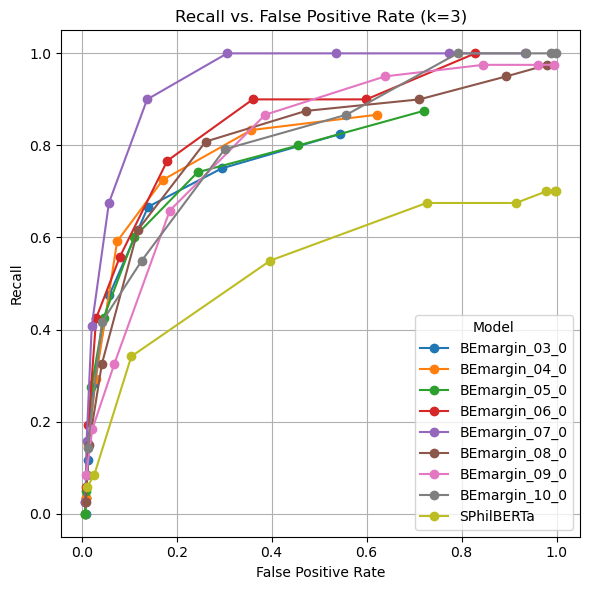

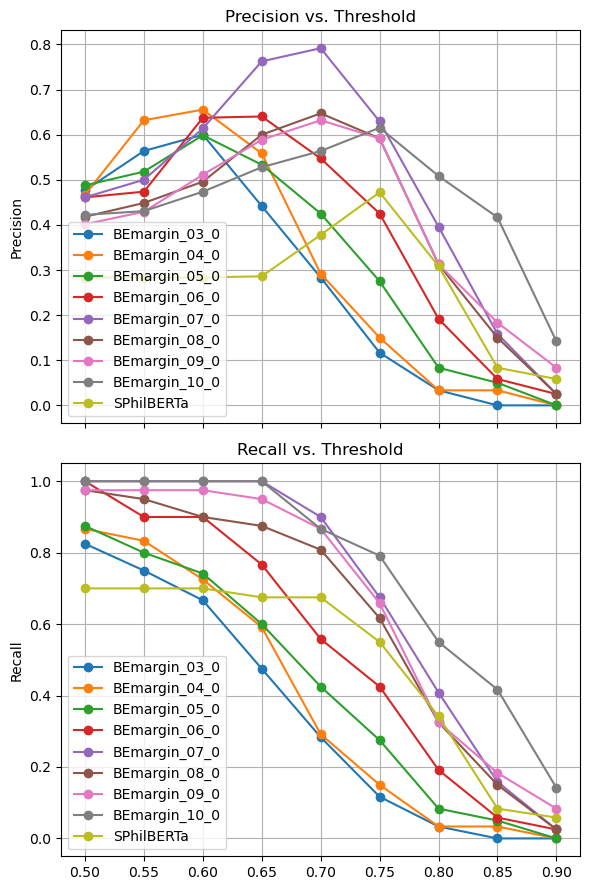

In [53]:
plot_retriever("BE/eval_BE_M_Ge.json", 3)

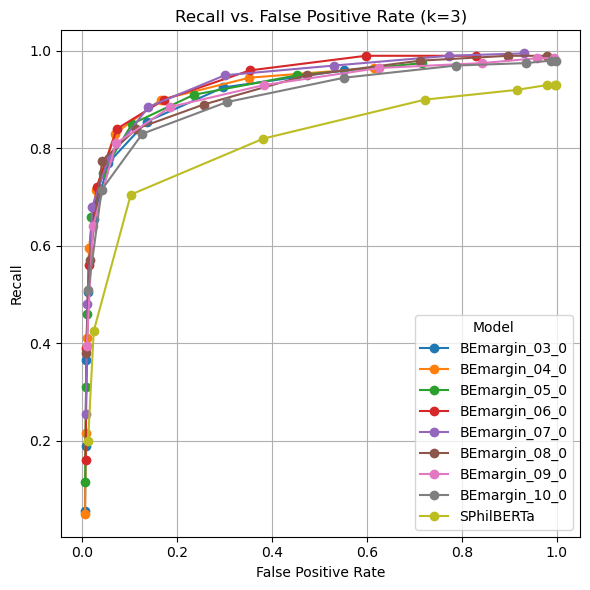

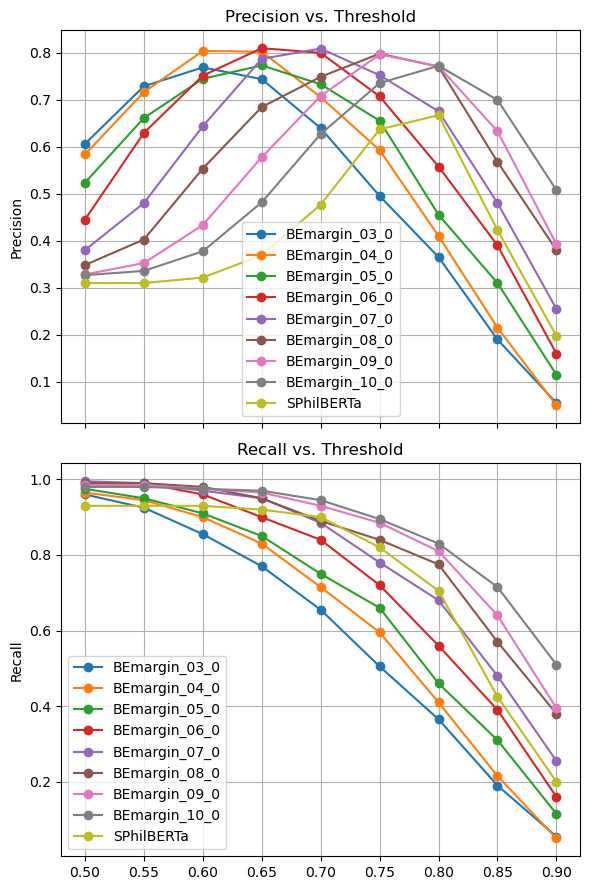

In [54]:
plot_retriever("BE/eval_BE_S_Ge.json", 3)

In [ ]:
plot_retriever("BE/eval-BE-QS.json", 1)

In [ ]:
plot_retriever("BE/eval-BE-QM.json", 1)

# CEP

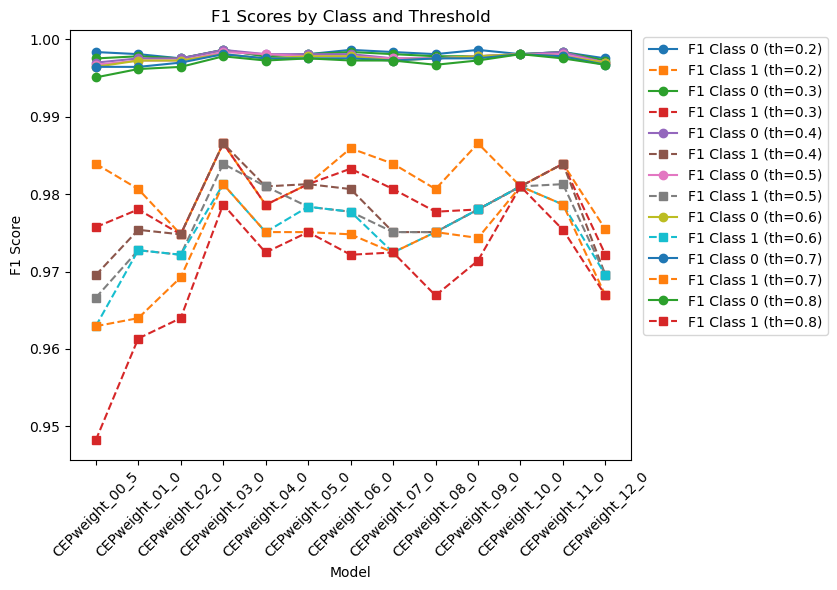

In [18]:
plot_reranker("CEP/EVAL-CEP-S1.json")

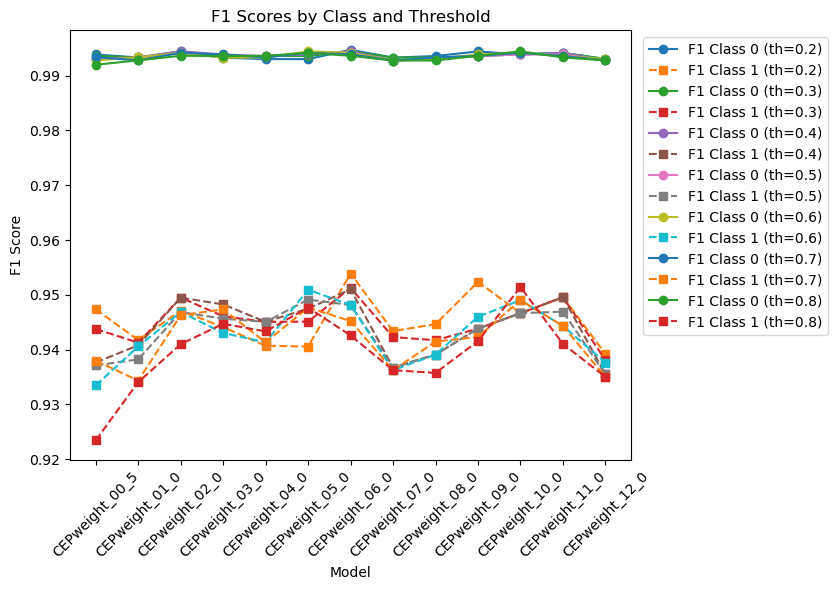

In [19]:
plot_reranker("CEP/EVAL-CEP-S2.json")

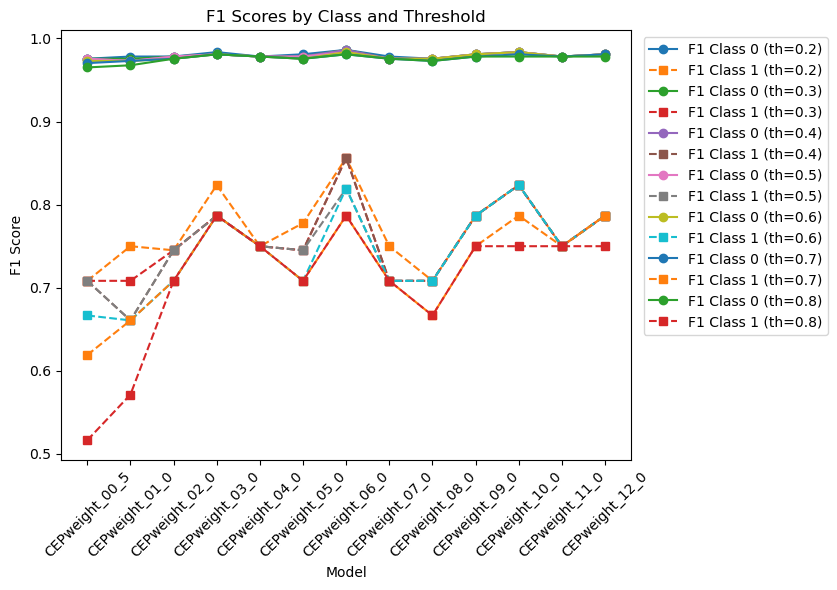

In [20]:
plot_reranker("CEP/EVAL-CEP-M1.json")

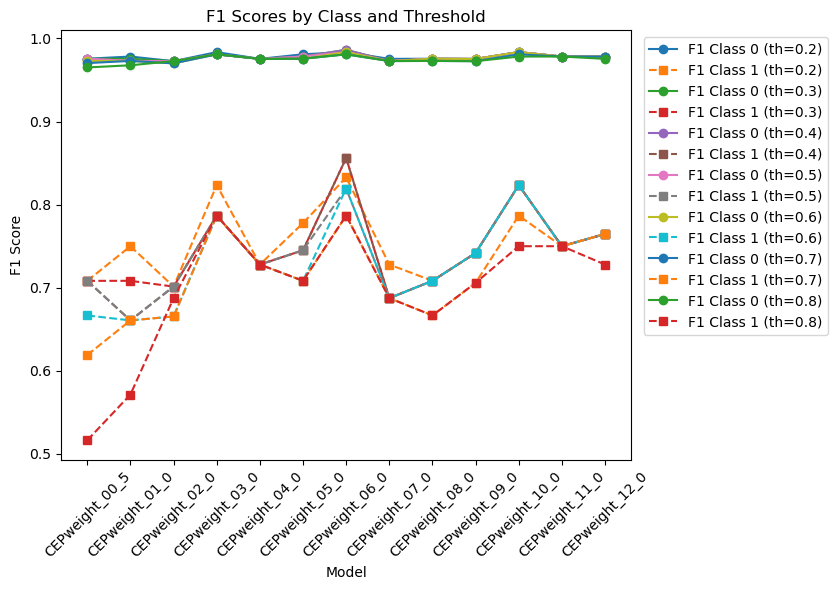

In [21]:
plot_reranker("CEP/EVAL-CEP-M2.json")

# CES

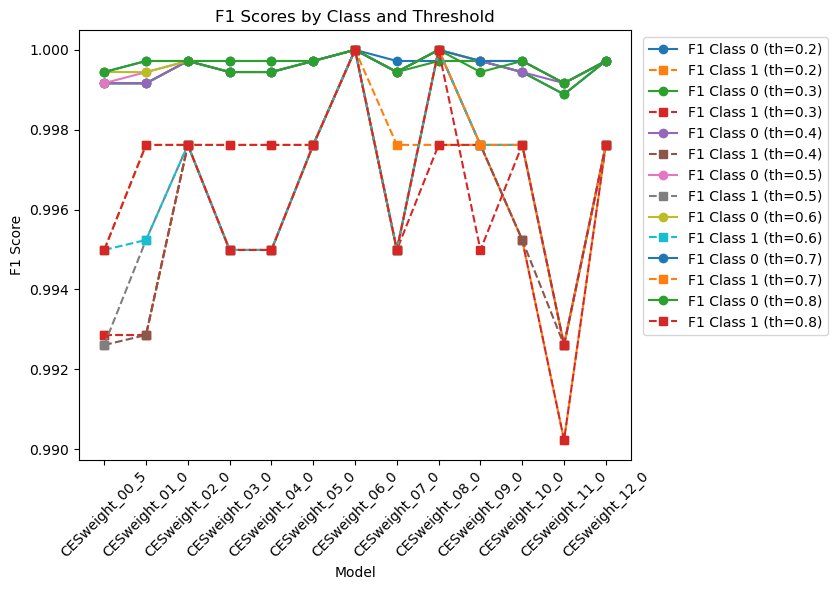

In [22]:
plot_reranker("CES/EVAL-CES-S1.json")

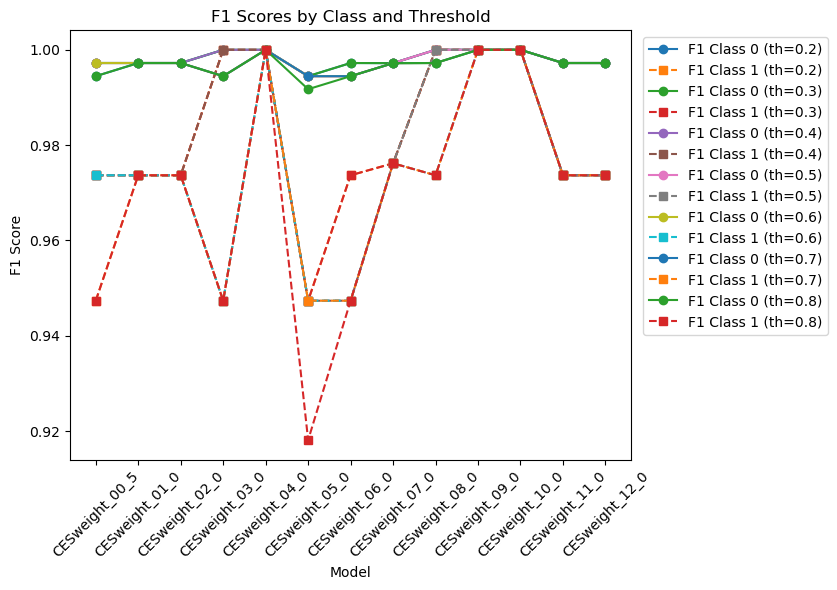

In [23]:
plot_reranker("CES/EVAL-CES-M1.json")

# Plotting Code

In [17]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


def plot_retriever(file_path, k):

    path = Path(f"results/{file_path}")
    with open(path, "r") as file:
        data = json.load(file)

    records = []
    for entry in data:
        model = entry["model"]
        for result in entry["results"]:
            if result["k"] == k:
                threshold = result["threshold"]
                precision = result["precision@k"]
                recall = result["recall@k"]
                f1 = result["f1@k"]
                fpr = result["false_positive_rate"]
                records.append({
                    "model": model,
                    "threshold": threshold,
                    "precision": precision,
                    "recall": recall,
                    "f1": f1,
                    "false_positive_rate": fpr
                })

    df = pd.DataFrame(records)

    avg_metrics = df.groupby(["model", "threshold"]).mean().reset_index()


    # Plotting recall vs false positive rate
    plt.figure(figsize=(6, 6))

    # Plot by model
    for model_name, group in avg_metrics.groupby("model"):
        plt.plot(group["false_positive_rate"], group["recall"], marker='o', label=model_name)

    plt.xlabel("False Positive Rate")
    plt.ylabel("Recall")
    plt.title(f"Recall vs. False Positive Rate (k={k})")
    plt.legend(title="Model")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"pdf/{file_path}_REvFPR.pdf", dpi=300, bbox_inches="tight")
    plt.show()

    # Plotting metrics vs threshold
    fig, axes = plt.subplots(2, 1, figsize=(6, 9), sharex=True)

    # Precision vs Threshold
    for model_name, group in avg_metrics.groupby("model"):
        axes[0].plot(group["threshold"], group["precision"], marker='o', label=model_name)
        axes[0].set_ylabel("Precision")
        axes[0].set_title("Precision vs. Threshold")
        axes[0].legend()
        axes[0].grid(True)

    # Recall vs Threshold
    for model_name, group in avg_metrics.groupby("model"):
        axes[1].plot(group["threshold"], group["recall"], marker='o', label=model_name)
        axes[1].set_ylabel("Recall")
        axes[1].set_title("Recall vs. Threshold")
        axes[1].legend()
        axes[1].grid(True)

    plt.tight_layout()
    plt.savefig(f"pdf/{file_path}_PRaRE.pdf", dpi=300, bbox_inches="tight")
    plt.show()
    


import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

def plot_reranker(file_path):
    path = Path(f"results/{file_path}")
    with open(path, "r") as file:
        data = json.load(file)

    records = []
    for entry in data:
        model = entry["model"]
        threshold = entry["threshold"]
        report = entry["classification_report"]

        precision_0 = report["0"]["precision"]
        recall_0 = report["0"]["recall"]
        precision_1 = report["1"]["precision"]
        recall_1 = report["1"]["recall"]
        support_1 = report["1"]["support"]

        # Compute false positives for class 1
        tp_1 = recall_1 * support_1
        fp_1 = tp_1 * (1 / precision_1 - 1) if precision_1 else 0

        # Compute F1 scores
        f1_0 = (2 * precision_0 * recall_0) / (precision_0 + recall_0) \
               if (precision_0 + recall_0) else 0
        f1_1 = (2 * precision_1 * recall_1) / (precision_1 + recall_1) \
               if (precision_1 + recall_1) else 0

        records.append({
            "model": model,
            "threshold": threshold,
            "precision_0": precision_0,
            "recall_0": recall_0,
            "precision_1": precision_1,
            "recall_1": recall_1,
            "false_positives_1": fp_1,
            "f1_0": f1_0,
            "f1_1": f1_1
        })

    df = pd.DataFrame(records)
    df["avg_precision"] = (df["precision_0"] + df["precision_1"]) / 2
    df["avg_recall"] = (df["recall_0"] + df["recall_1"]) / 2

    grouped = df.groupby(["model", "threshold"]).mean().reset_index()
    thresholds = sorted(grouped["threshold"].unique())
    models = grouped["model"].unique()
    x = range(len(models))

    # --- Third Figure: F1 Scores ---
    plt.figure(figsize=(10, 6))
    for threshold in thresholds:
        sub_df = grouped[grouped["threshold"] == threshold]
        plt.plot(x, sub_df["f1_0"], marker='o', linestyle='-',
                 label=f'F1 Class 0 (th={threshold})')
        plt.plot(x, sub_df["f1_1"], marker='s', linestyle='--',
                 label=f'F1 Class 1 (th={threshold})')

    plt.xticks(x, models, rotation=45)
    plt.xlabel("Model")
    plt.ylabel("F1 Score")
    plt.title("F1 Scores by Class and Threshold")
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0))
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(f"pdf/{file_path}_F1.pdf",
                dpi=300, bbox_inches="tight")
    plt.show()




In [ ]:


    # --- First Figure: Precision and Recall Plots ---
    fig, axes = plt.subplots(4, 1, figsize=(10, 11), sharex=True)
    metric_keys = ["precision_0", "recall_0", "precision_1", "recall_1"]
    titles = ["Precision (Class 0)", "Recall (Class 0)",
              "Precision (Class 1)", "Recall (Class 1)"]

    for ax, metric, title in zip(axes, metric_keys, titles):
        for threshold in thresholds:
            sub_df = grouped[grouped["threshold"] == threshold]
            ax.plot(x, sub_df[metric], marker='o', label=f'th={threshold}')
        ax.set_ylabel("Score")
        ax.set_title(title)
        ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0))

    axes[-1].set_xticks(x)
    axes[-1].set_xticklabels(models, rotation=45)
    axes[-1].set_xlabel("Model")

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(f"pdf/{file_path}_PRaRE.pdf",
                dpi=300, bbox_inches="tight")
    plt.show()

    # --- Second Figure: Recall vs. False Positives (Class 1) ---
    plt.figure(figsize=(8, 6))
    for model in models:
        sub_df = grouped[grouped["model"] == model]
        plt.plot(sub_df["false_positives_1"], sub_df["recall_1"],
                 marker='x', linestyle='--', label=f'{model}')

    plt.xlabel("False Positives (Class 1)")
    plt.ylabel("Recall (Class 1)")
    plt.title("Recall vs. False Positives (Class 1)")
    plt.legend(loc='best')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"pdf/{file_path}_REvFPR.pdf",
                dpi=300, bbox_inches="tight")
    plt.show()

# Confusion Matrix

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay

def conf_mat(name, file_path, output_dir="confusion_matrices"):
    # Load the new JSON data
    file_path = Path(file_path)
    with open(file_path, "r") as f:
        data = json.load(f)
    
    # Extract unique threshold_p values
    threshold_values = sorted(set(entry["reranker_p_threshold"] for entry in data))
    
    # Set the label set
    label_set = ["quote", "fuzzy_quote", "paraphrase", "similar_sentence", "irrelevant"]
    label_to_index = {label: i for i, label in enumerate(label_set)}
    n_labels = len(label_set)

    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Dictionary to store confusion matrices by threshold
    confusion_matrices_by_threshold = {}
    
    # Aggregate confusion matrices for each threshold
    for threshold in threshold_values:
        aggregated_matrix = np.zeros((n_labels, n_labels), dtype=int)
        for entry in data:
            if entry["reranker_p_threshold"] == threshold:
                aggregated_matrix += np.array(entry["confusion_matrix"]["matrix"])
        confusion_matrices_by_threshold[threshold] = aggregated_matrix
    
    # Plotting all confusion matrices
    for threshold, matrix in confusion_matrices_by_threshold.items():
        normalized_matrix = matrix.astype('float') / matrix.sum(axis=1, keepdims=True)
    
        fig1, ax1 = plt.subplots(figsize=(8, 6))
        ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=label_set).plot(
            ax=ax1, cmap="Blues", xticks_rotation=45
        )
        ax1.set_title(f"Confusion Matrix")
        fig1.tight_layout()
        fig1.savefig(output_path / f"confusion_matrix_{name}_{threshold}.pdf")

        fig2, ax2 = plt.subplots(figsize=(8, 6))
        ConfusionMatrixDisplay(confusion_matrix=normalized_matrix, display_labels=label_set).plot(
            ax=ax2, cmap="Blues", xticks_rotation=45
        )
        ax2.set_title(f"Normalized Confusion")
        fig2.tight_layout()
        fig2.savefig(output_path / f"confusion_matrix_{name}_{threshold}_normalized.pdf")
    
    plt.show()



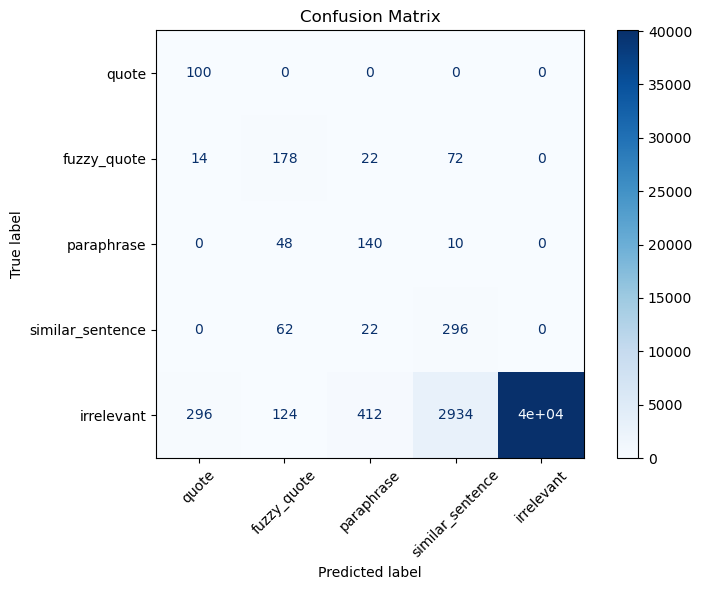

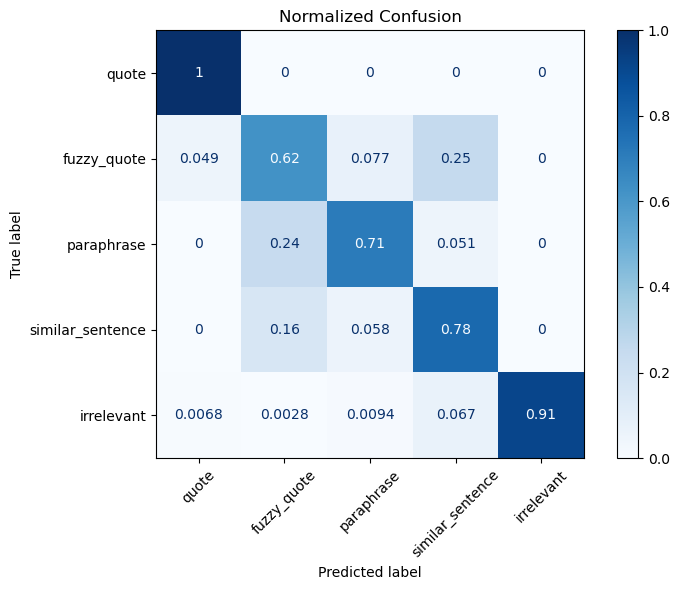

In [51]:
conf_mat("PL-S", "results/PL/EVAL-PL-S.json")

In [43]:
conf_mat("results/PL/EVAL-PL-M.json")

FileNotFoundError: [Errno 2] No such file or directory: 'results/PL/EVAL-PL-M.json'

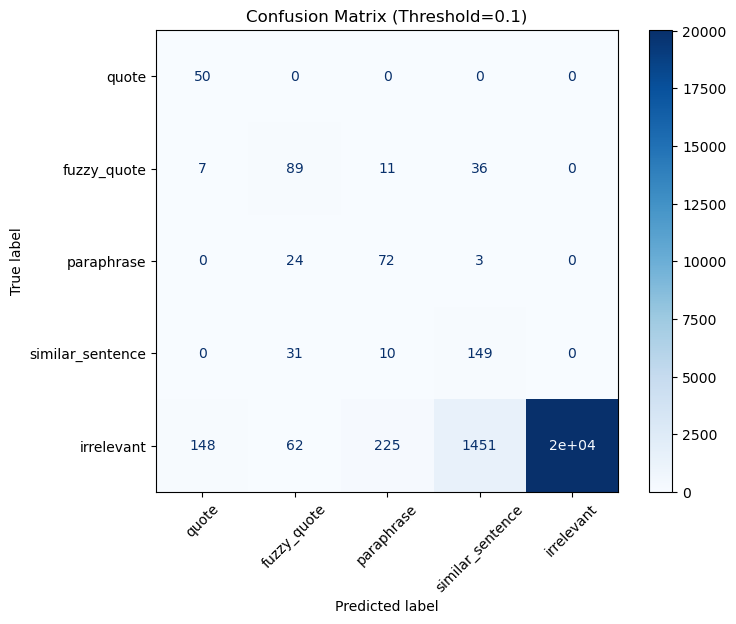

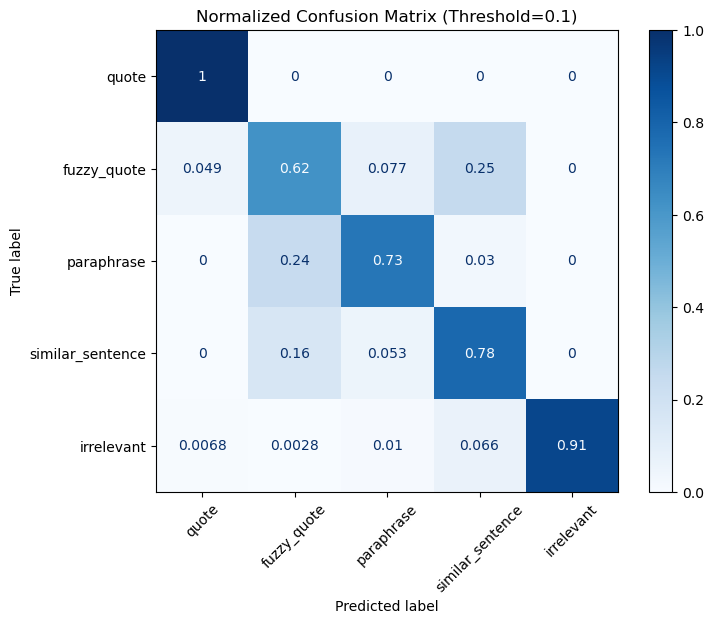

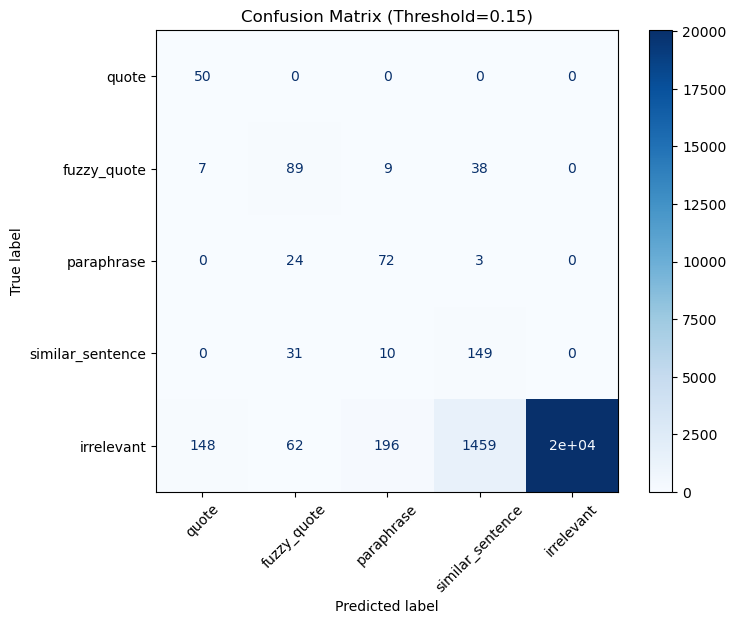

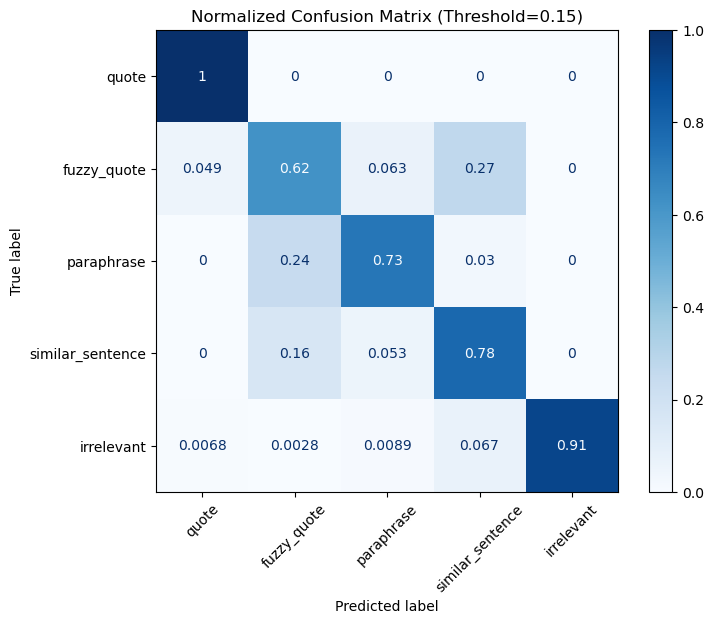

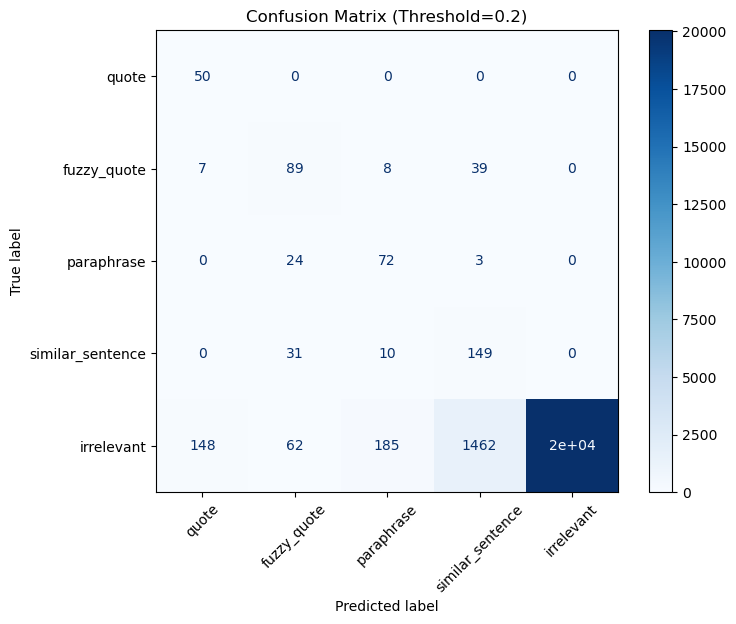

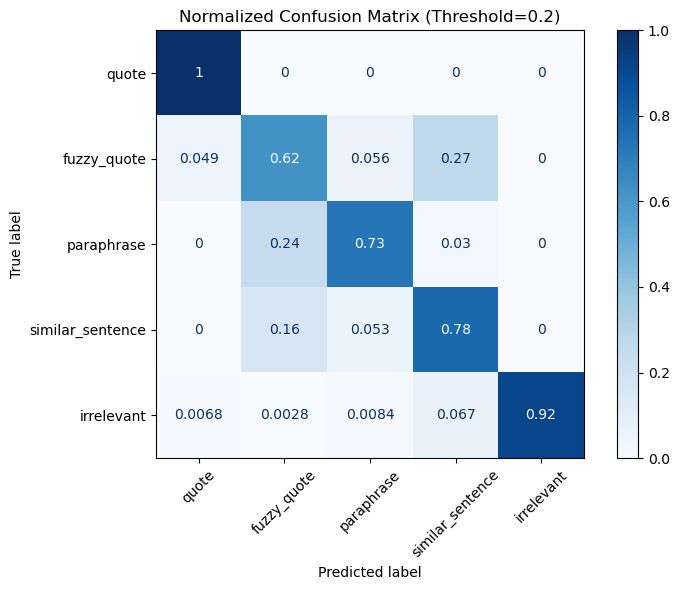

In [44]:
conf_mat("results/PL/EVAL2-PL-S.json")

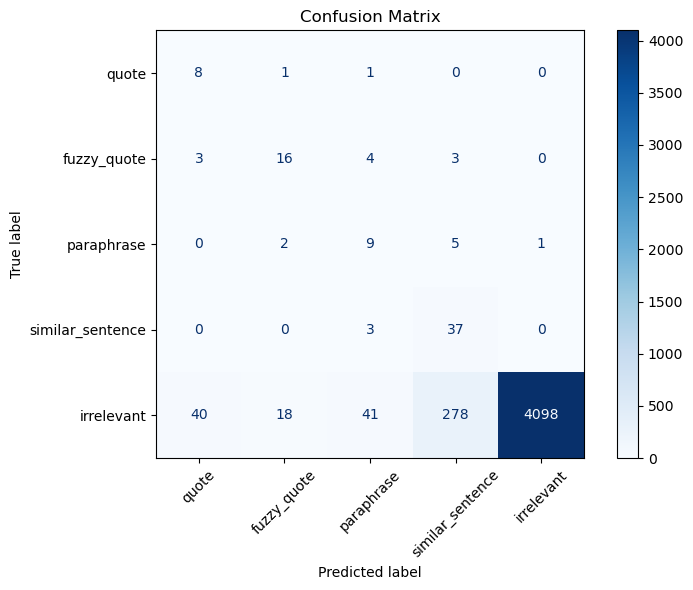

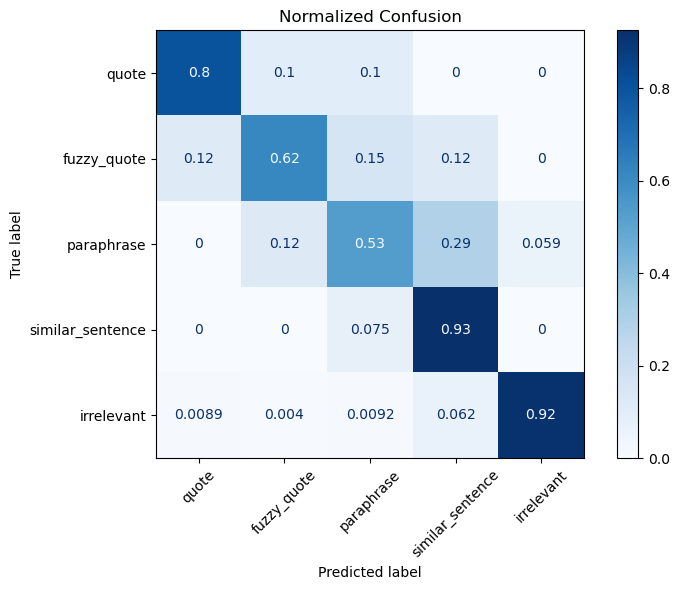

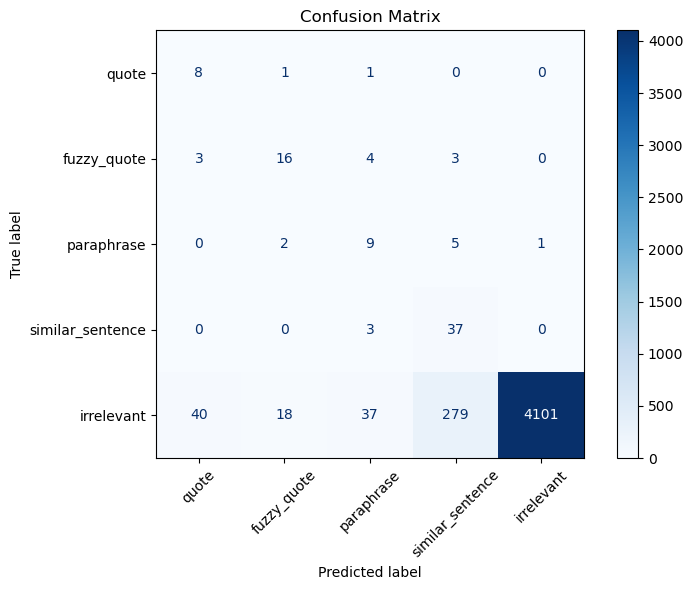

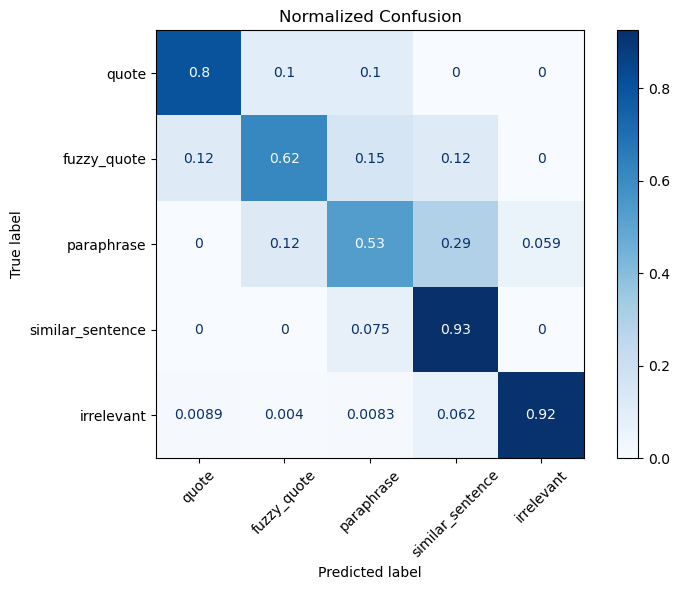

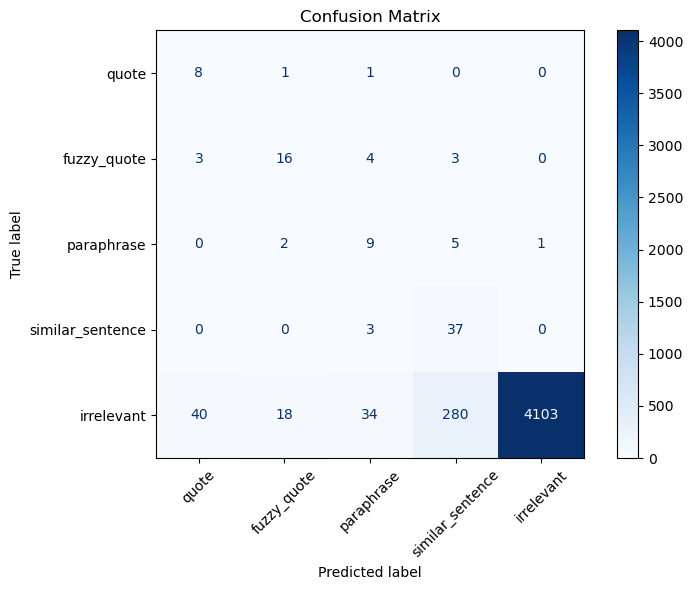

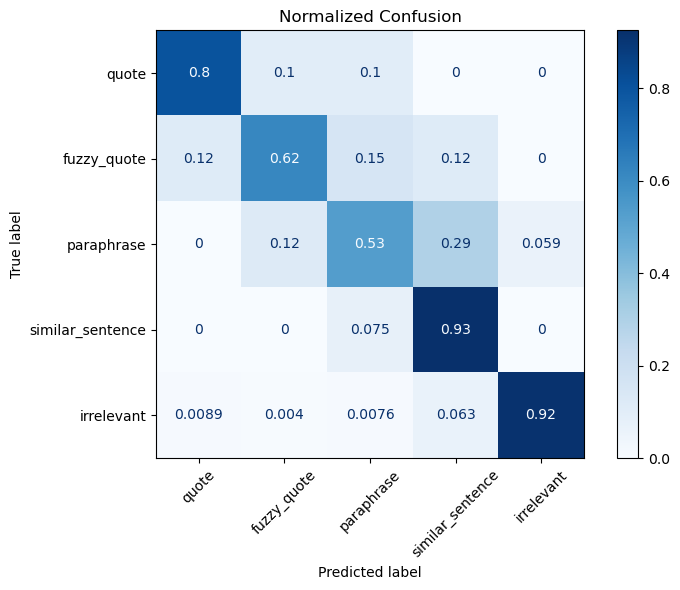

In [52]:
conf_mat("PL-M", "results/PL/EVAL2-PL-M.json")